              English               Sanskrit
0     <start> I <end>     <start> अहम् <end>
1    <start> me <end>     <start> माम् <end>
2   <start> you <end>    <start> त्वम् <end>
3    <start> go <end>     <start> गच्छ <end>
4  <start> went <end>  <start> अगच्छत् <end>
Vocab size (Sanskrit): 1267
Vocab size (English): 1138

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 512)            648704    ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0      

Epoch 32/55
21/21 [==============================] - 5s 233ms/step - loss: 0.7473 - accuracy: 0.8443 - val_loss: 1.9420 - val_accuracy: 0.8328
Epoch 33/55
21/21 [==============================] - 5s 233ms/step - loss: 0.7197 - accuracy: 0.8445 - val_loss: 1.9019 - val_accuracy: 0.8339
Epoch 34/55
21/21 [==============================] - 5s 232ms/step - loss: 0.6969 - accuracy: 0.8489 - val_loss: 1.9537 - val_accuracy: 0.8370
Epoch 35/55
21/21 [==============================] - 5s 229ms/step - loss: 0.6765 - accuracy: 0.8502 - val_loss: 1.9831 - val_accuracy: 0.8359
Epoch 36/55
21/21 [==============================] - 5s 227ms/step - loss: 0.6535 - accuracy: 0.8570 - val_loss: 2.0145 - val_accuracy: 0.8385
Epoch 37/55
21/21 [==============================] - 5s 225ms/step - loss: 0.6352 - accuracy: 0.8604 - val_loss: 1.9829 - val_accuracy: 0.8406
Epoch 38/55
21/21 [==============================] - 5s 227ms/step - loss: 0.6117 - accuracy: 0.8644 - val_loss: 2.0420 - val_accuracy: 0.8390

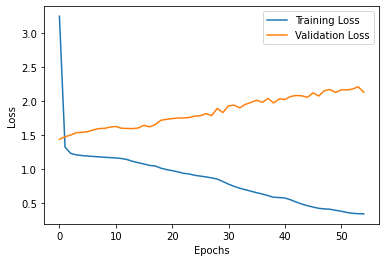

In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate

# Load dataset
df = pd.read_excel("C:/Users/harsh/Desktop/dict.xlsx")

# Add <start> and <end> tokens to each sentence
df['Sanskrit'] = df['Sanskrit'].apply(lambda x: f"<start> {x} <end>")
df['English'] = df['English'].apply(lambda x: f"<start> {x} <end>")

print(df.head())

# Create and fit tokenizers for both Sanskrit and English
tokenizer_sanskrit = Tokenizer(filters='')
tokenizer_sanskrit.fit_on_texts(df['Sanskrit'])
tokenizer_english = Tokenizer(filters='')
tokenizer_english.fit_on_texts(df['English'])

# print(tokenizer_sanskrit.word_index)
# print(tokenizer_english.word_index)
# Vocabulary sizes
vocab_size_sanskrit = len(tokenizer_sanskrit.word_index) + 1
vocab_size_english = len(tokenizer_english.word_index) + 1
print(f"Vocab size (Sanskrit): {vocab_size_sanskrit}")
print(f"Vocab size (English): {vocab_size_english}")

# Convert sentences to sequences
sanskrit_sequences = tokenizer_sanskrit.texts_to_sequences(df['Sanskrit'])
english_sequences = tokenizer_english.texts_to_sequences(df['English'])

# Pad sequences
max_len = max(max(len(seq) for seq in sanskrit_sequences), max(len(seq) for seq in english_sequences))
sanskrit_padded = pad_sequences(sanskrit_sequences, maxlen=max_len, padding='post')
english_padded = pad_sequences(english_sequences, maxlen=max_len, padding='post')

# Define input and target data for training
english_input_padded = pad_sequences(english_sequences, maxlen=max_len + 1, padding='post')[:, :-1]
english_target_padded = pad_sequences(english_sequences, maxlen=max_len + 1, padding='post')[:, 1:]

# Define the Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.units = units
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, encoder_outputs, decoder_outputs):
        decoder_outputs_expanded = tf.expand_dims(decoder_outputs, 1)
        score = self.V(tf.nn.tanh(self.W1(encoder_outputs) + self.W2(decoder_outputs_expanded)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * encoder_outputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

    def get_config(self):
        config = super(Attention, self).get_config()
        config.update({'units': self.units})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Define encoder-decoder model with Attention
encoder_input = Input(shape=(None,))
encoder_embedding = Embedding(input_dim=vocab_size_sanskrit, output_dim=512)(encoder_input)
encoder_outputs, state_h = GRU(512, return_sequences=True, return_state=True)(encoder_embedding)

decoder_input = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=vocab_size_english, output_dim=512)(decoder_input)
decoder_outputs, _ = GRU(512, return_sequences=True, return_state=True)(decoder_embedding, initial_state=state_h)

attention = Attention(units=64)
context_vector, attention_weights = attention(encoder_outputs, decoder_outputs)
decoder_concat_input = Concatenate(axis=-1)([context_vector, decoder_outputs])

output = Dense(vocab_size_english, activation='softmax')(decoder_concat_input)
model = tf.keras.Model([encoder_input, decoder_input], output)

# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model with a few more epochs
history=model.fit([sanskrit_padded, english_input_padded], english_target_padded, epochs=55, batch_size=64, validation_split=0.2)

# Save the model and tokenizers
model.save("C:/Users/harsh/Downloads/sanskrit_to_english_model2.keras")
with open('C:/Users/harsh/Desktop/tokenizer_sanskrit.pkl', 'wb') as f:
    pickle.dump(tokenizer_sanskrit, f)
with open('C:/Users/harsh/Desktop/tokenizer_english.pkl', 'wb') as f:
    pickle.dump(tokenizer_english, f)

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [6]:
import tensorflow as tf
import numpy as np
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the Attention layer (kept as is)
class Attention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.units = units
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, encoder_outputs, decoder_outputs):
        decoder_outputs_expanded = tf.expand_dims(decoder_outputs, 1)
        score = self.V(tf.nn.tanh(self.W1(encoder_outputs) + self.W2(decoder_outputs_expanded)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * encoder_outputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

    def get_config(self):
        config = super(Attention, self).get_config()
        config.update({'units': self.units})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Load the model with custom Attention layer
custom_objects = {
    'Attention': Attention,
}

model = tf.keras.models.load_model("C:/Users/harsh/Downloads/sanskrit_to_english_model2.keras", custom_objects=custom_objects)

# Load the tokenizers
with open("C:/Users/harsh/Desktop/tokenizer_sanskrit.pkl", 'rb') as f:
    tokenizer_sanskrit = pickle.load(f)

with open("C:/Users/harsh/Desktop/tokenizer_english.pkl", 'rb') as f:
    tokenizer_english = pickle.load(f)

# Preprocess input sentence
def preprocess_sentence(sentence, tokenizer, max_len):
    seq = tokenizer.texts_to_sequences([f"<start> {sentence} <end>"])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')
    return padded_seq

# Decode the predicted sequence into English
def decode_sequence(sequence, tokenizer):
    reverse_word_index = dict(map(reversed, tokenizer.word_index.items()))
    return ' '.join([reverse_word_index.get(i, '') for i in sequence if i > 0])

# Generate an English translation for an input Sanskrit sequence
def predict_sequence(input_seq, max_len_output):
    start_token_index = tokenizer_english.word_index.get("<start>")
    end_token_index = tokenizer_english.word_index.get("<end>")

    decoder_input_seq = np.zeros((1, max_len_output))
    decoder_input_seq[0, 0] = start_token_index

    predicted_seq = []

    for i in range(1, max_len_output):
        predictions = model.predict([input_seq, decoder_input_seq])
        predicted_token_index = np.argmax(predictions[0, i-1, :])
        #print(f"Predicted token at step {i}: {predicted_token_index}")

        if predicted_token_index == end_token_index:
            break

        predicted_seq.append(predicted_token_index)
        decoder_input_seq[0, i] = predicted_token_index

    return np.array(predicted_seq)

# Define max length for input and output sequences
max_len_input = max_len
max_len_output = max_len

# Example sentence for translation
#sanskrit_sentence = "अगच्छत्" 
# sanskrit_sentence = "वयम्" # Replace with any Sanskrit sentence
# input_seq = preprocess_sentence(sanskrit_sentence, tokenizer_sanskrit, max_len_input)

# # Predict and decode the sequence
# predicted_seq = predict_sequence(input_seq, max_len_output)
# english_sentence = decode_sequence(predicted_seq, tokenizer_english)
# print("Predicted English Sentence:", english_sentence)
#test_sentences = ["अगच्छत्", "कृते", "सर्वत्र"]
test_sentences = [
    "वयम्",
    "ते",
    "एतत्",
    "तत्",
    "कः",
    "किम्",
    "कुत्र",
    "कदा",
    "किमर्थम्",
    "कथम्",
    "कतमः",
    "आगच्छ",
    "उपविश",
    "तिष्ठ",
    "वद",
    "शृणु",
    "अश",
    "पिब",
    "स्वप",
    "चर"
]

for sentence in test_sentences:
    input_seq = preprocess_sentence(sentence, tokenizer_sanskrit, max_len_input)
    predicted_seq = predict_sequence(input_seq, max_len_output)
    english_sentence = decode_sequence(predicted_seq, tokenizer_english)
    print(f"Sanskrit: {sentence} -> Predicted English word: {english_sentence}")

# Tokenized sequences
# print("Sample Sanskrit Sequence:", tokenizer_sanskrit.texts_to_sequences(["अगच्छत्"]))
# print("Sample English Sequence:", tokenizer_english.texts_to_sequences(["<start> brother <end>"]))
# Display the mapping of tokens to words
# print(tokenizer_sanskrit.word_index)
# print(tokenizer_english.word_index)
# print("Sanskrit Padded Shape:", sanskrit_padded.shape)
# print("English Input Padded Shape:", english_input_padded.shape)
# print("English Target Padded Shape:", english_target_padded.shape)


1/1 [==============================] - 0s 61ms/step
Sanskrit: वयम् -> Predicted English word: republic
1/1 [==============================] - 0s 58ms/step
Sanskrit: ते -> Predicted English word: run
1/1 [==============================] - 0s 59ms/step
Sanskrit: एतत् -> Predicted English word: approach
1/1 [==============================] - 0s 63ms/step
Sanskrit: तत् -> Predicted English word: wellness
1/1 [==============================] - 0s 59ms/step
Sanskrit: कः -> Predicted English word: morning
1/1 [==============================] - 0s 65ms/step
Sanskrit: किम् -> Predicted English word: advice
1/1 [==============================] - 0s 59ms/step
Sanskrit: कुत्र -> Predicted English word: without
1/1 [==============================] - 0s 58ms/step
Sanskrit: कदा -> Predicted English word: religion
1/1 [==============================] - 0s 58ms/step
Sanskrit: किमर्थम् -> Predicted English word: why
1/1 [==============================] - 0s 55ms/step
Sanskrit: कथम् -> Predicted English 